In [1]:
import sys
sys.path.append('/mydata/watres/quentin/code/FLOW/hourly_analysis/')
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import os
import GAMCR
import numpy as np

mode = '_all'
with open('/mydata/watres/quentin/code/FLOW/hourly_analysis/RES_GAMCR/real_data_pred/GISID2NSE{0}.pkl'.format(mode), 'rb') as handle:
    GISID2NSE = pickle.load(handle)


NSE_min = 0.3
all_sites = []
for key, val in GISID2NSE.items():
    if val>=NSE_min:
        all_sites.append(key)

/tmp/ipykernel_59292/2786151787.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def peak_vs_area(global_path, all_sites, log_abs=False, weighted=True, alpha=0.1, maxT=24*20, log_ordo=False, show_sites_labels=True, figsave=True):
    site2tf = {}
    cmap = get_cmap('tab20')  # Choose a colormap with distinct colors (you can try 'tab20', 'Set1', etc.)
    colors = [cmap(i) for i in np.linspace(0, 1, len(all_sites))]  # Generate distinct colors for each site
    markers = ['o', 's', 'D', '^' ] #, 'v', '>', '<', '*', 'P', 'X', 'H', 'h', '+', 'x']  # Define a list of markers
    num_markers = len(markers)
    id_site = 0
    peaks = []
    areas = []
    peaks_true = []
    areas_true = []
    site_colors = []  # List to store colors for each site
    site_markers = []  # List to store markers for each site

    for site in all_sites:
        folder = os.path.join(global_path, site, 'results')

        H_weighted_avg = np.load(os.path.join(folder, 'H_weighted_avg.npy'))
        H_avg = np.load(os.path.join(folder, 'H_avg.npy'))
        m = H_avg.shape[1]
    
        with open(os.path.join(folder, 'groups_precip.pkl'), 'rb') as handle:
            groups_precip = pickle.load(handle)
        with open(os.path.join(folder, 'groups_wetness.pkl'), 'rb') as handle:
            groups_wetness = pickle.load(handle)
        with open(os.path.join(folder, 'group2p_range.pkl'), 'rb') as handle:
            group2p_range = pickle.load(handle)
        with open(os.path.join(folder, 'group2q_range.pkl'), 'rb') as handle:
            group2q_range = pickle.load(handle)
        with open(os.path.join(folder, 'group2nbpoints.pkl'), 'rb') as handle:
            group2nbpoints = pickle.load(handle)

        try:
            H_weighted_avg_true = np.load(os.path.join(folder, 'H_weighted_avg_true.npy'))
            H_avg_true = np.load(os.path.join(folder, 'H_avg_true.npy'))
            with open(os.path.join(folder, 'group2nbpoints_true.pkl'), 'rb') as handle:
                group2nbpoints_true = pickle.load(handle)
            true_tfs = True
            tf_true = np.zeros(m)
            norm_true = 0
        except:
            true_tfs = False
            pass
        
        x = np.arange(0, m, 1) / 24
        tf = np.zeros(m)
        norm = 0
    
        for j in range(1, len(groups_precip)):
            for k in range(len(groups_wetness)):
                if weighted:
                    if group2nbpoints[len(groups_wetness)*j+k] > 1:
                        norm += group2nbpoints[len(groups_wetness)*j+k]
                        tf += H_weighted_avg[len(groups_wetness)*j+k,:] * group2nbpoints[len(groups_wetness)*j+k]
                    if true_tfs:
                        if group2nbpoints_true[len(groups_wetness)*j+k] > 1:
                            norm_true += group2nbpoints_true[len(groups_wetness)*j+k]
                            tf_true += H_weighted_avg_true[len(groups_wetness)*j+k,:] * group2nbpoints_true[len(groups_wetness)*j+k]
                else:
                    if group2nbpoints[len(groups_wetness)*j+k] > 1:
                        norm += group2nbpoints[len(groups_wetness)*j+k]
                        tf += H_avg[len(groups_wetness)*j+k,:] * group2nbpoints[len(groups_wetness)*j+k]
                    if true_tfs:
                        if group2nbpoints_true[len(groups_wetness)*j+k] > 1:
                            norm_true += group2nbpoints_true[len(groups_wetness)*j+k]
                            tf_true += H_avg_true[len(groups_wetness)*j+k,:] * group2nbpoints_true[len(groups_wetness)*j+k]

        tf /= norm
        if true_tfs:
            tf_true /= norm_true
            peaks_true.append(np.max(tf_true))
            areas_true.append(np.sum(tf_true))

        peaks.append(np.max(tf))
        areas.append(np.sum(tf))
        
        site_colors.append(colors[id_site])  # Store color for the current site
        site_markers.append(markers[id_site % num_markers])  # Store marker for the current site
        id_site += 1

    plt.figure(figsize=(5, 5))
    if log_abs:
        abs = np.log10(peaks)
    else:
        abs = peaks
    if log_ordo:
        ordo = np.log10(areas)
        for i in range(len(all_sites)):
            plt.scatter(abs[i], ordo[i], c=site_colors[i], marker=site_markers[i], label=all_sites[i])
        if true_tfs:
            plt.plot(abs, np.log10(areas), marker='*')            
    else:
        ordo = areas
        for i in range(len(all_sites)):
            plt.scatter(abs[i], areas[i], c=site_colors[i], marker=site_markers[i], label=all_sites[i])

        if true_tfs:
            plt.plot(abs, areas, marker='*')            

    # Create a multi-column legend for the sites
    num_cols = int(np.sqrt(len(all_sites))) // 2  # You can adjust this based on the number of sites
    handles = [plt.Line2D([0], [0], marker=site_markers[i], color='w', markerfacecolor=site_colors[i], markersize=8, label=site)
               for i, site in enumerate(all_sites)]
    plt.legend(handles=handles, title="Sites (GISID)", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=num_cols)

    if weighted:
        if log_ordo:
            title = 'Log(AUC NRF)'
        else:
            title = 'AUC NRF'
    else:
        if log_ordo:
            title = 'Log(AUC RRD)'
        else:
            title = 'AUC RRD'
    
    plt.ylabel(title, fontsize=14)
    if weighted:
        if not log_abs:
            title += '_peak'
            plt.xlabel('Peak height NRF', fontsize=14)
        else:
            title += '_logpeak'
            plt.xlabel('Log(Peak height NRF)', fontsize=14)
    else:
        if not log_abs:
            title += '_peak'
            plt.xlabel('Peak height RRD', fontsize=14)
        else:
            title += '_logpeak'
            plt.xlabel('Log(Peak height RRD)', fontsize=14)
    if true_tfs:
        plt.scatter([], [], marker='*', label='Ground truth')
        plt.scatter([], [], marker='x', label='GAMCR')
        plt.legend()
    
    title += 'peak_AUC.png'
    if figsave:
        plt.savefig(title, dpi=250, bbox_inches='tight')
    plt.show()



/tmp/ipykernel_59292/2623290346.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Choose a colormap with distinct colors (you can try 'tab20', 'Set1', etc.)
/tmp/ipykernel_59292/2623290346.py:95: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(abs[i], ordo[i], c=site_colors[i], marker=site_markers[i], label=all_sites[i])


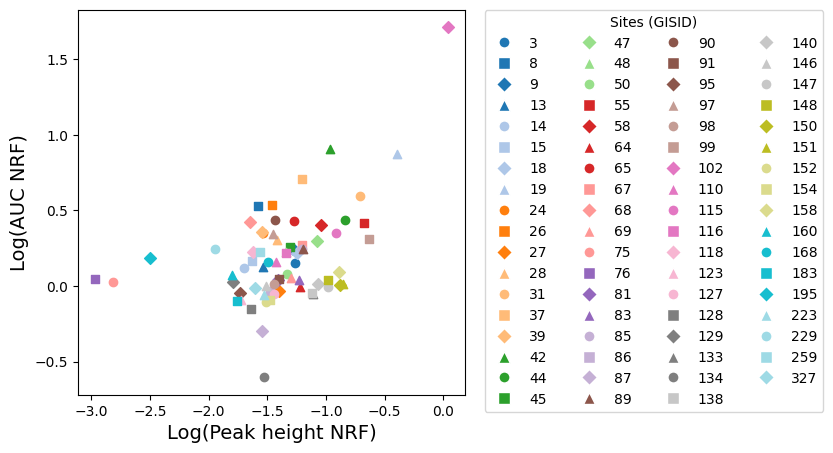

In [4]:
global_path = '/mydata/watres/quentin/code/FLOW/hourly_analysis/RES_GAMCR/real_data/'
peak_vs_area(global_path, all_sites, log_abs=True, weighted=True, alpha=0.1, maxT=24*60, log_ordo=True, figsave=True)

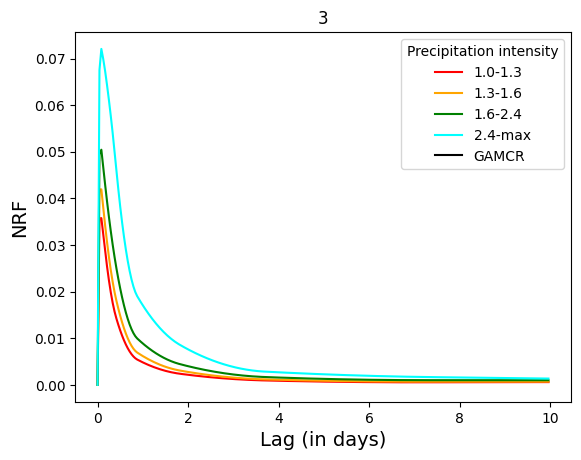

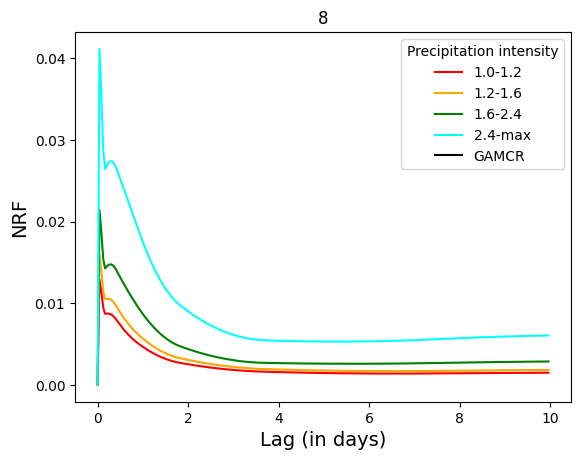

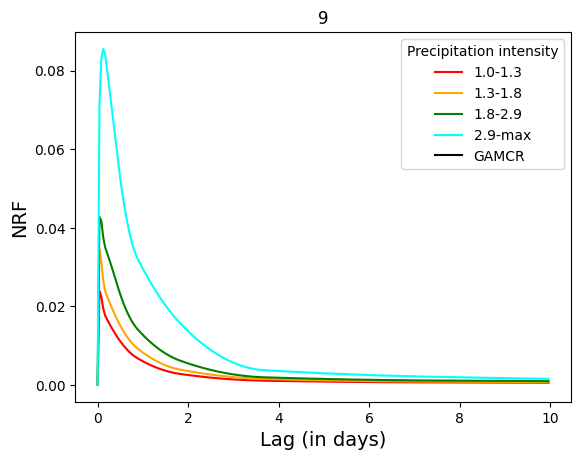

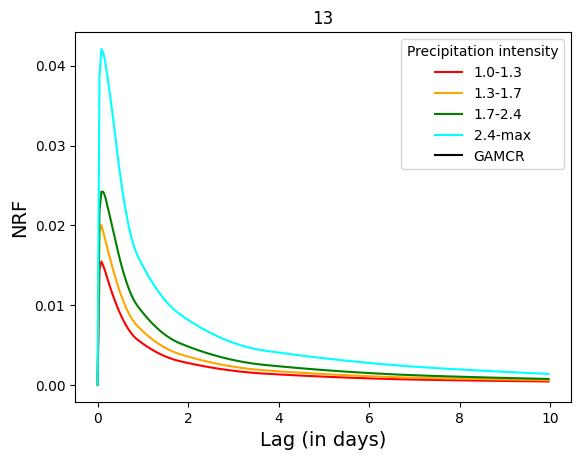

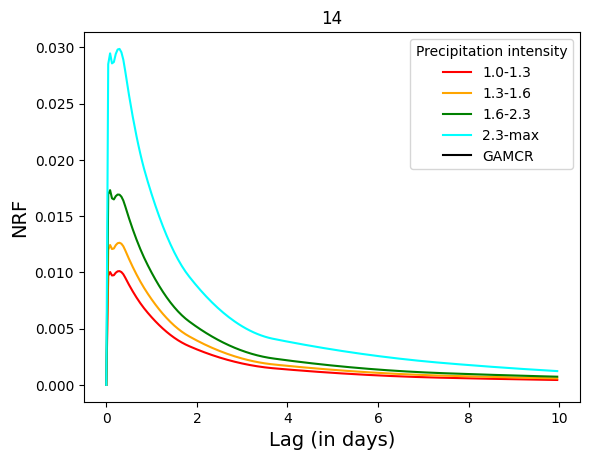

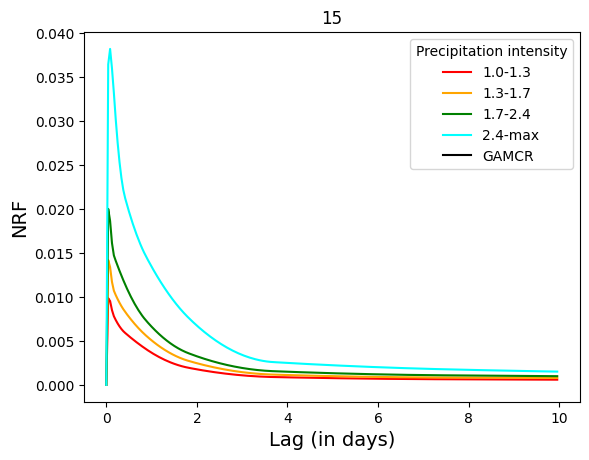

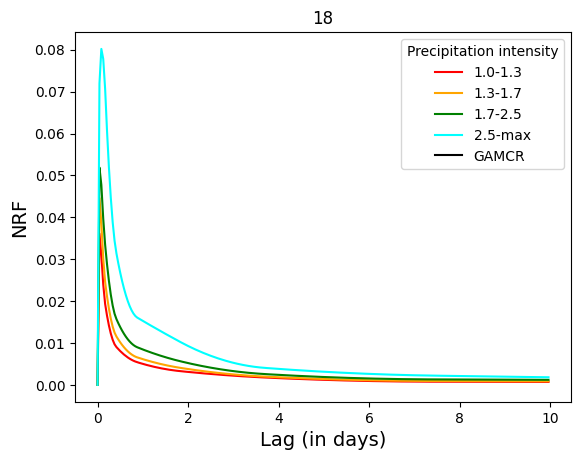

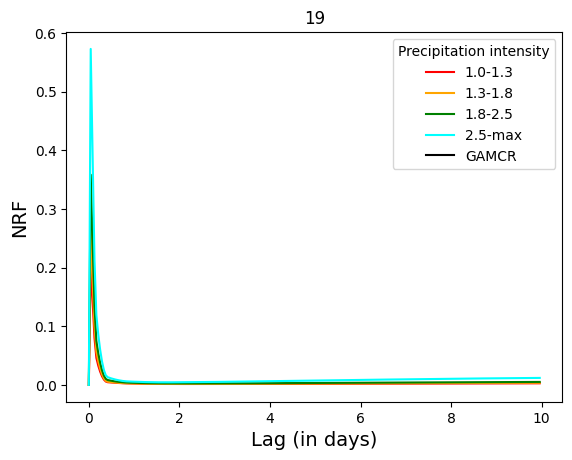

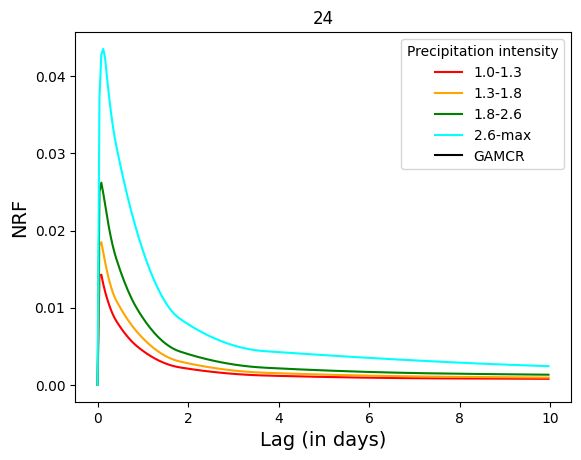

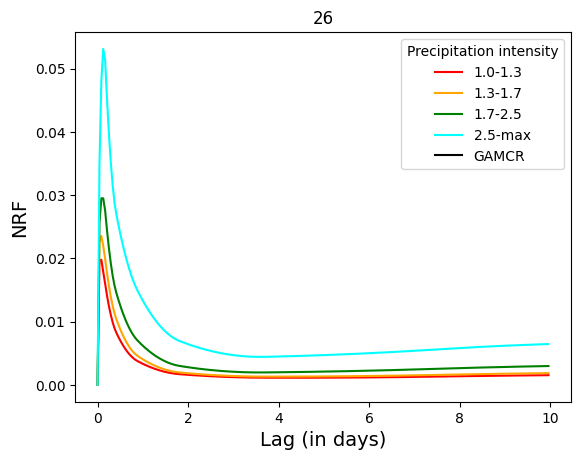

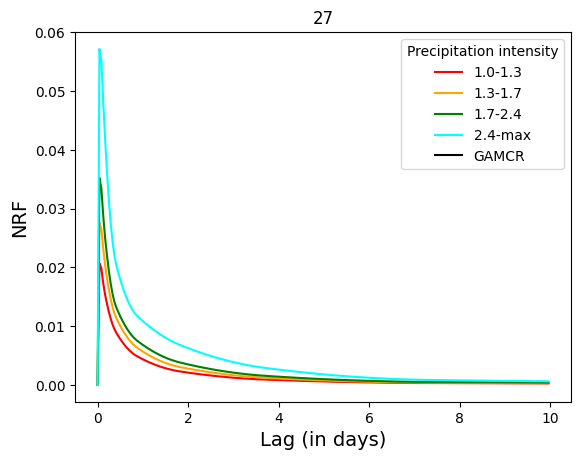

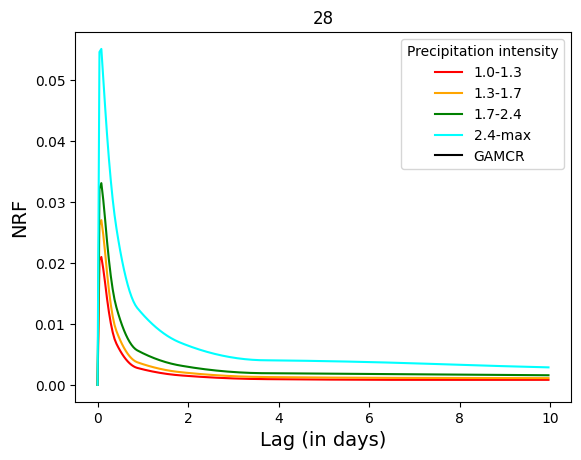

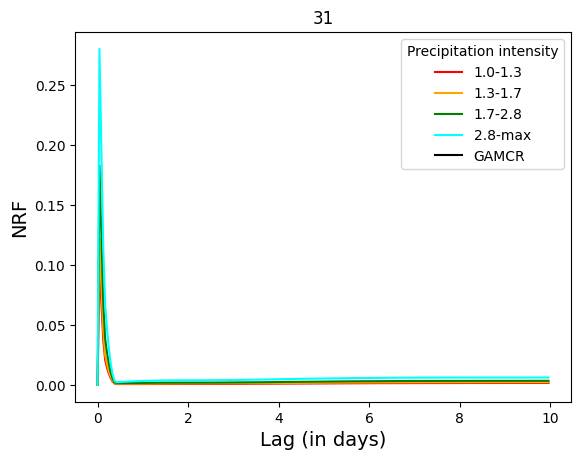

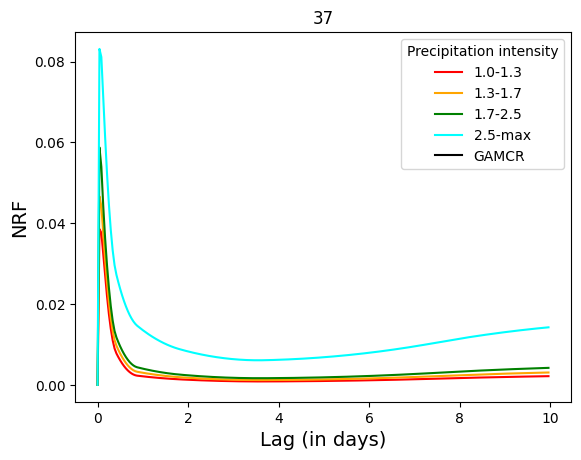

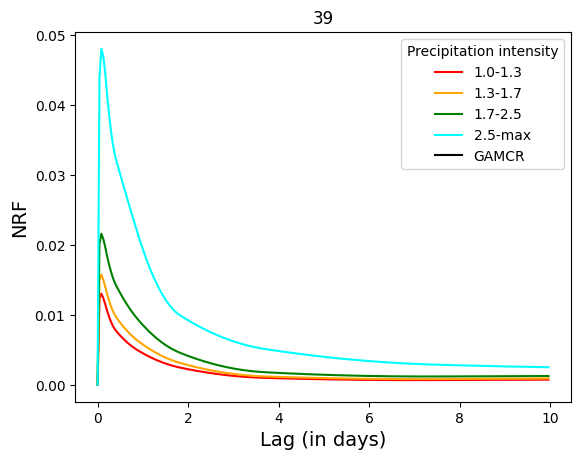

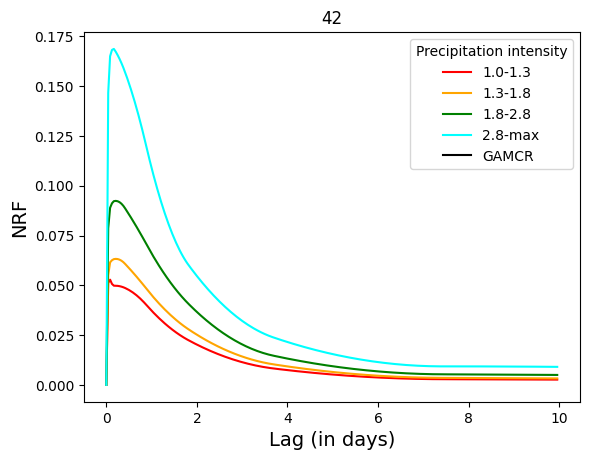

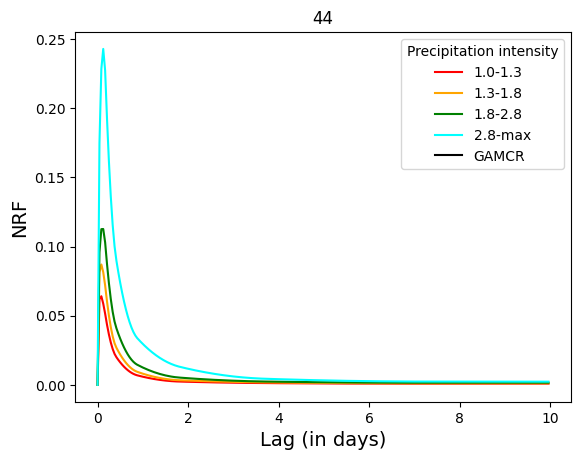

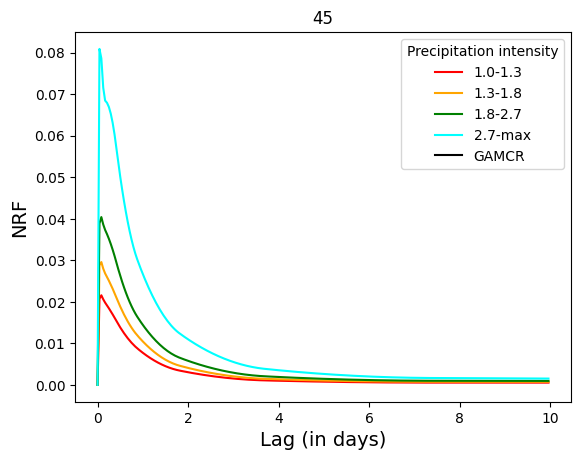

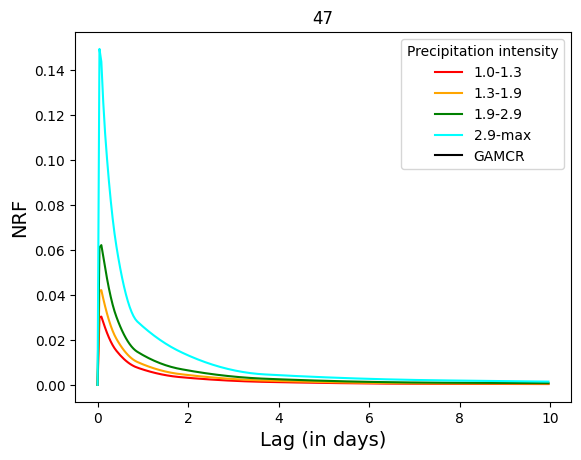

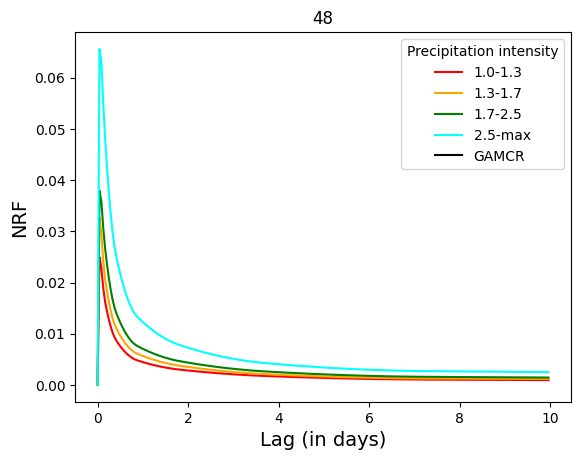

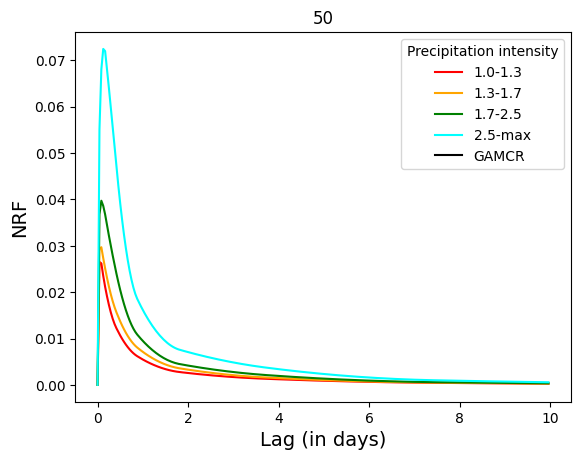

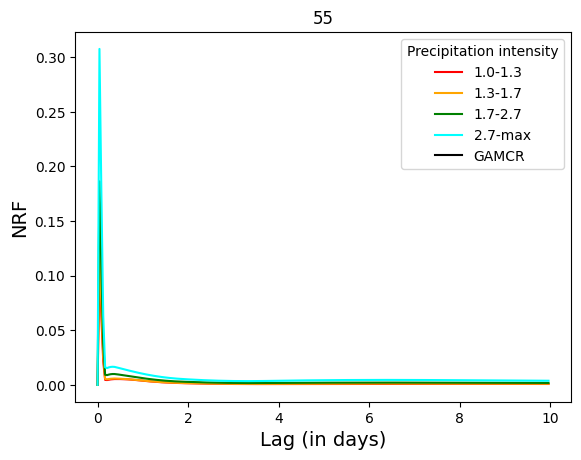

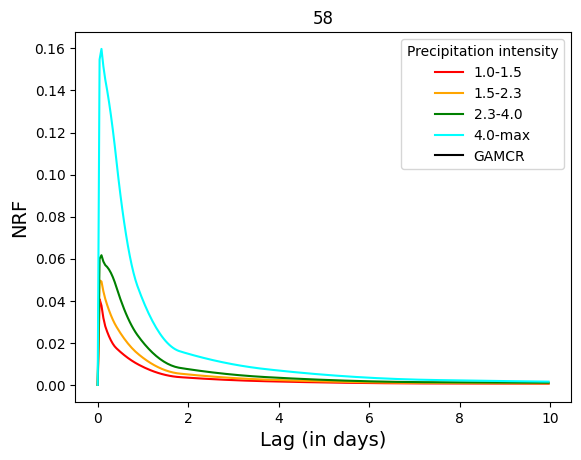

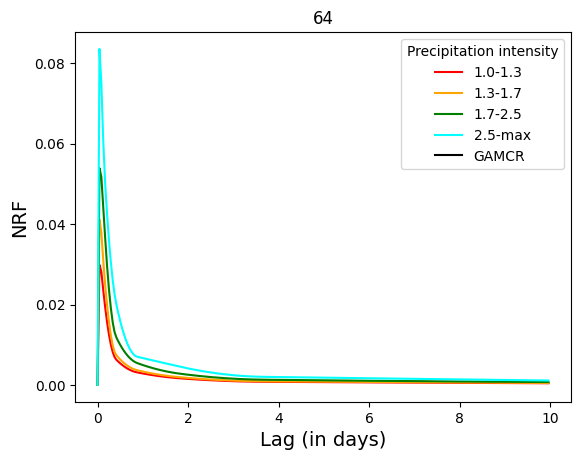

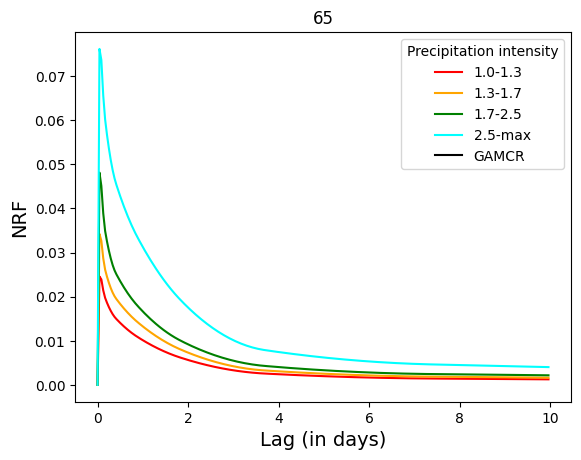

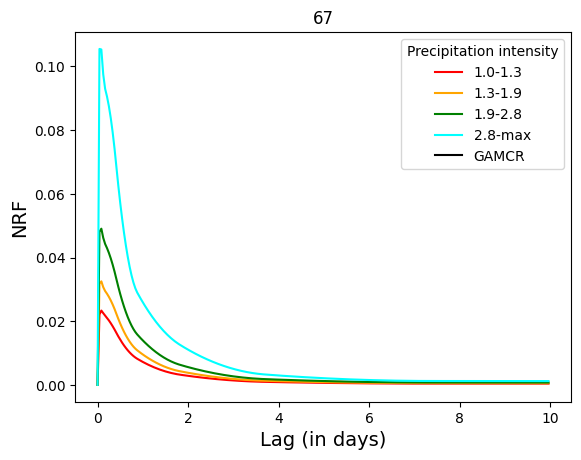

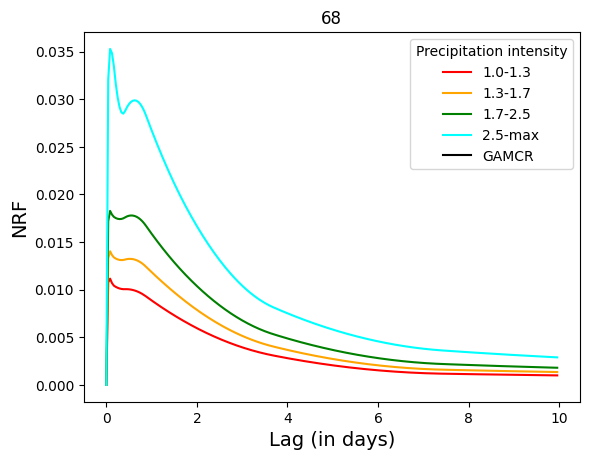

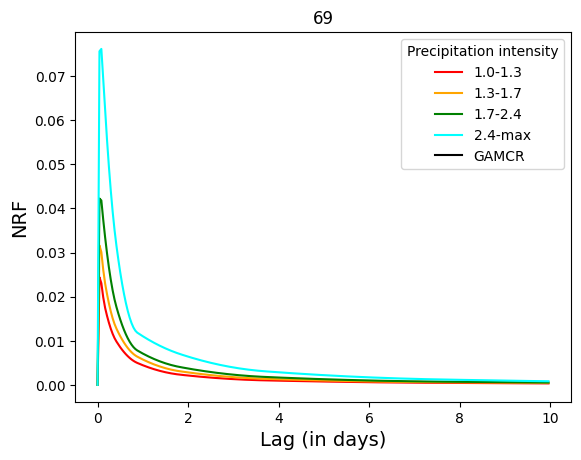

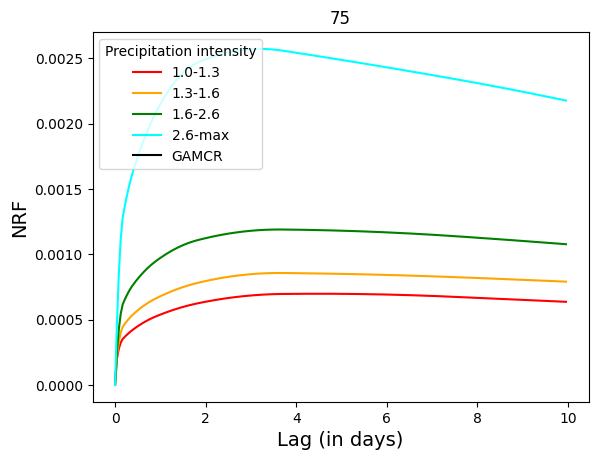

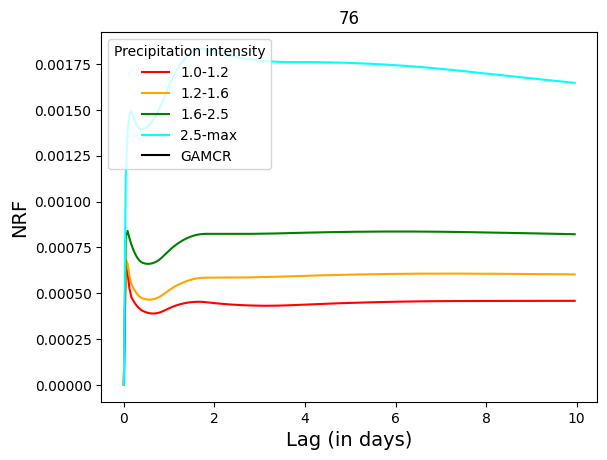

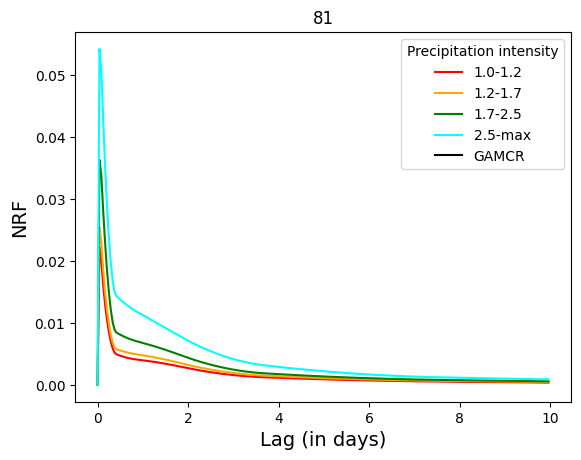

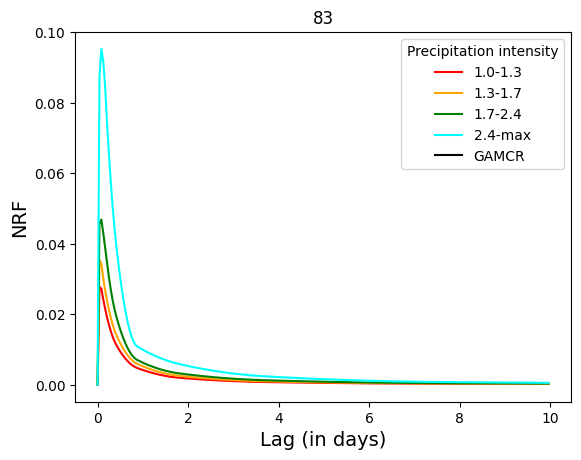

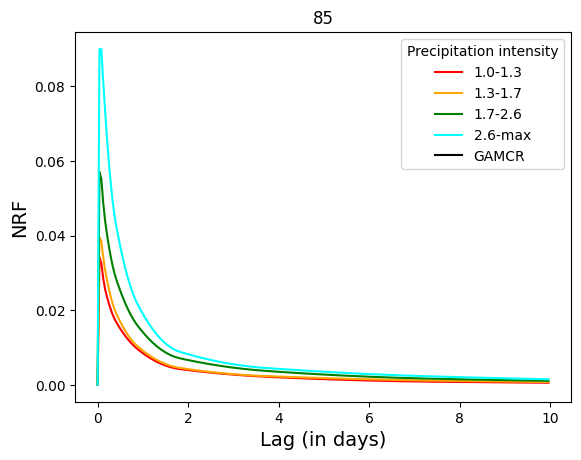

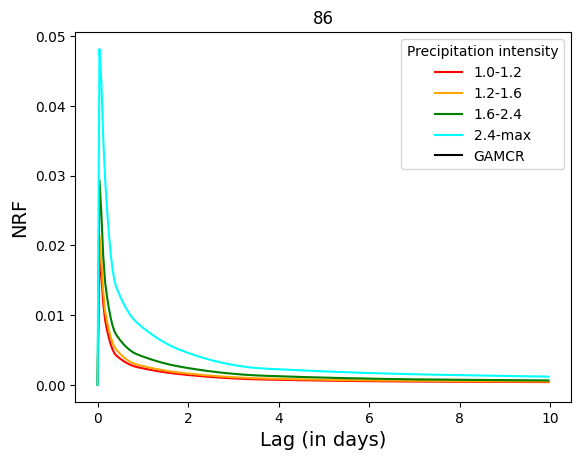

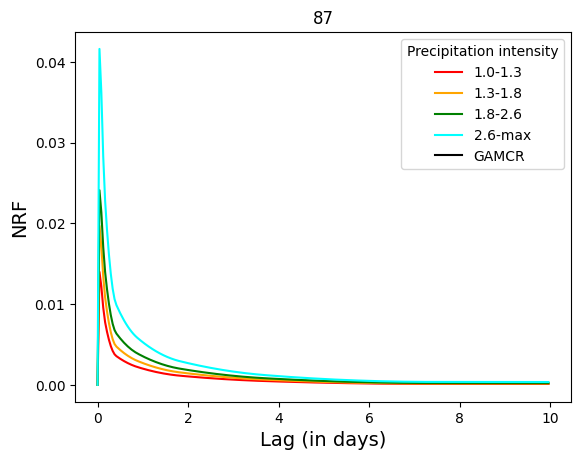

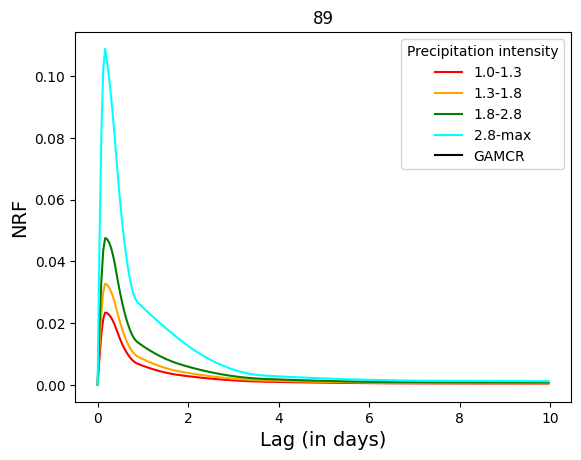

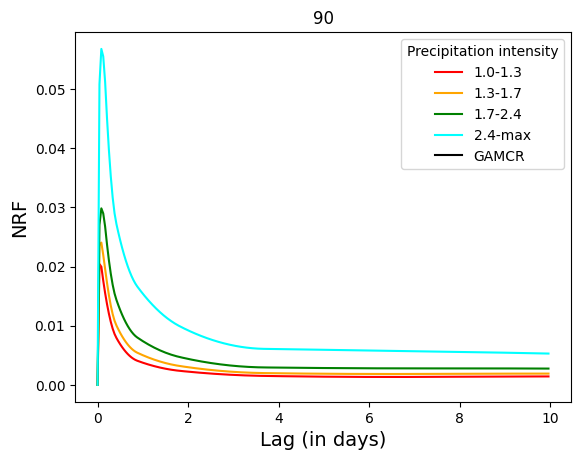

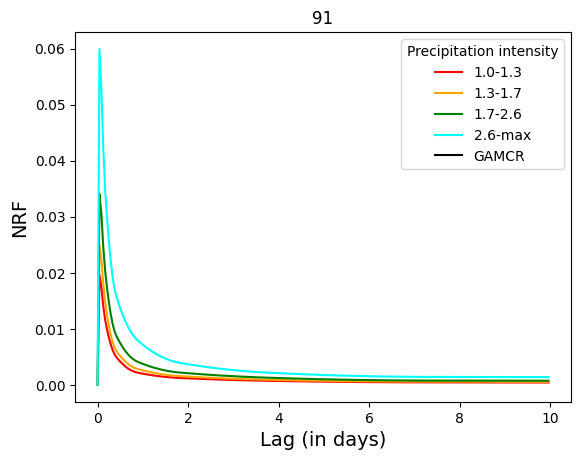

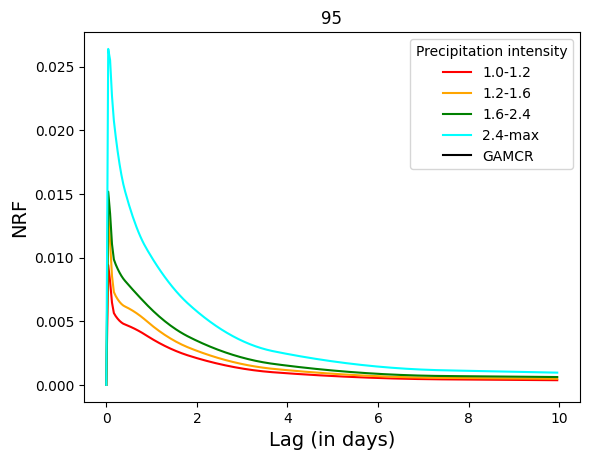

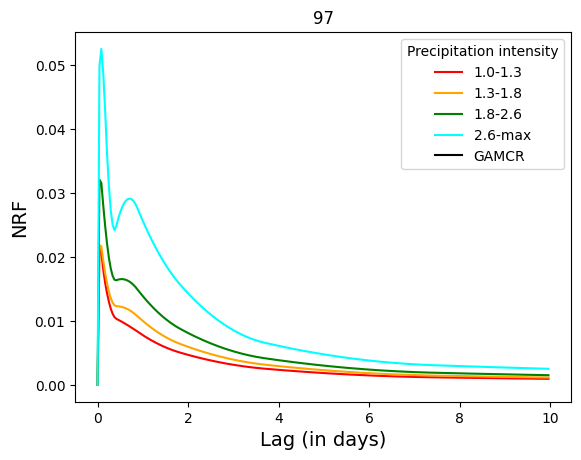

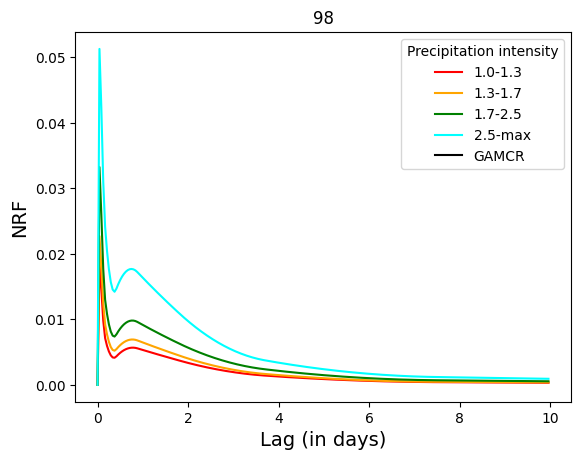

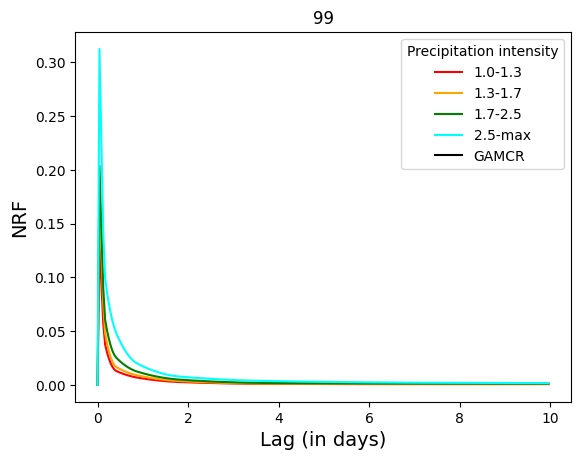

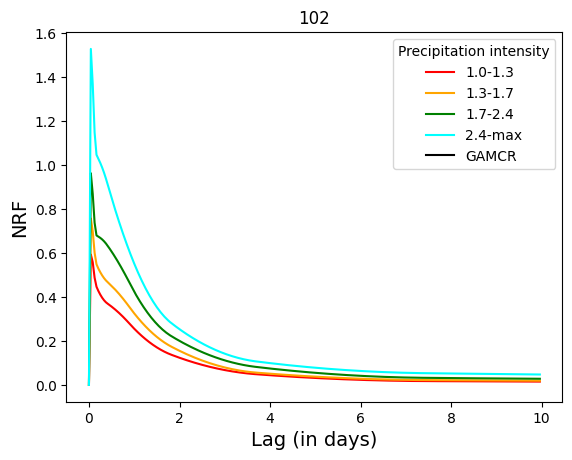

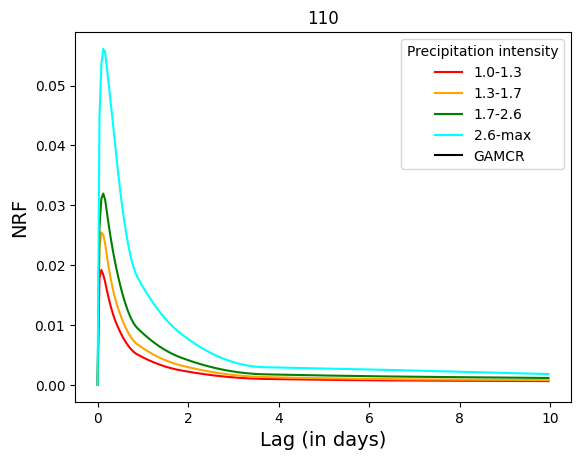

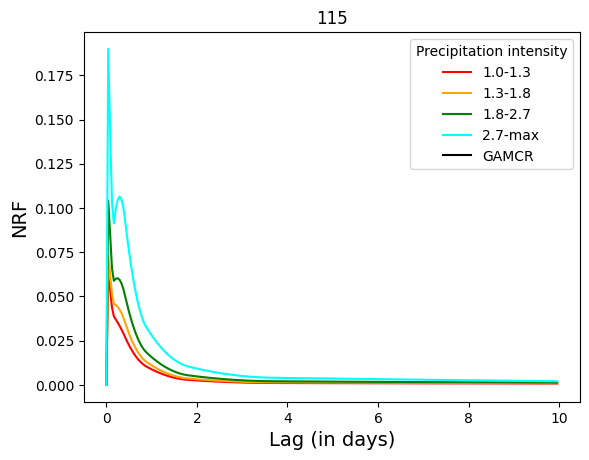

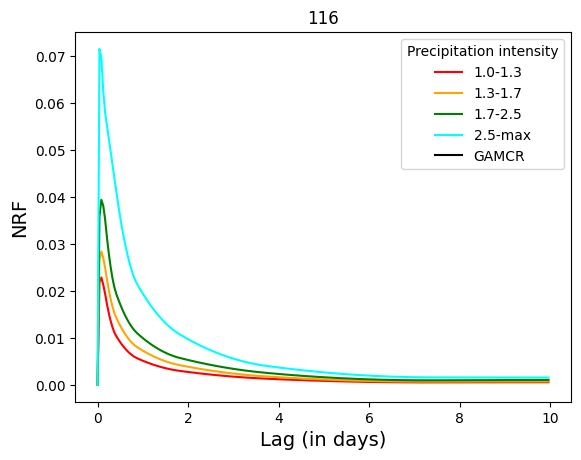

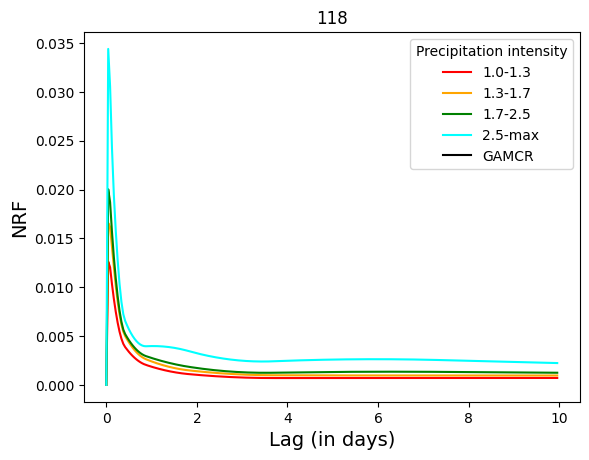

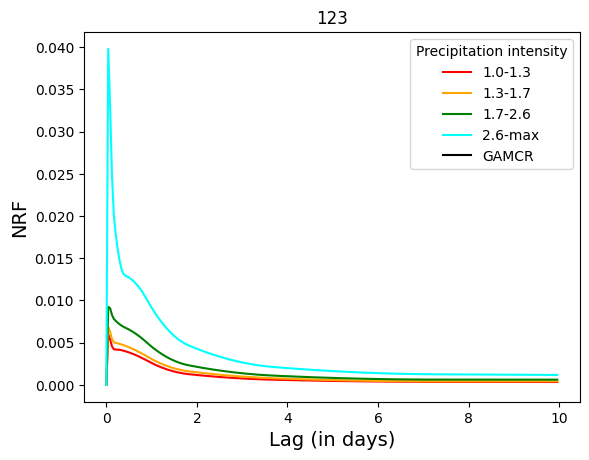

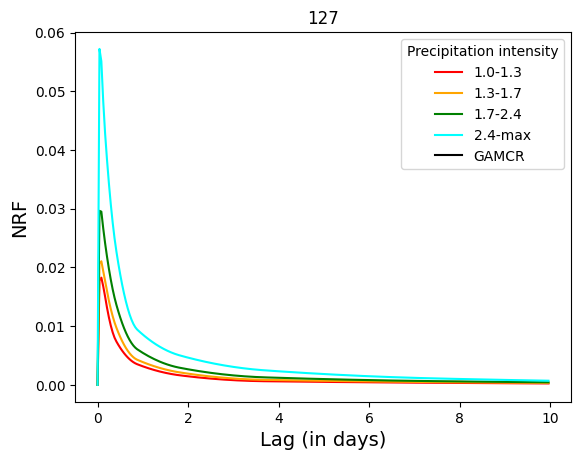

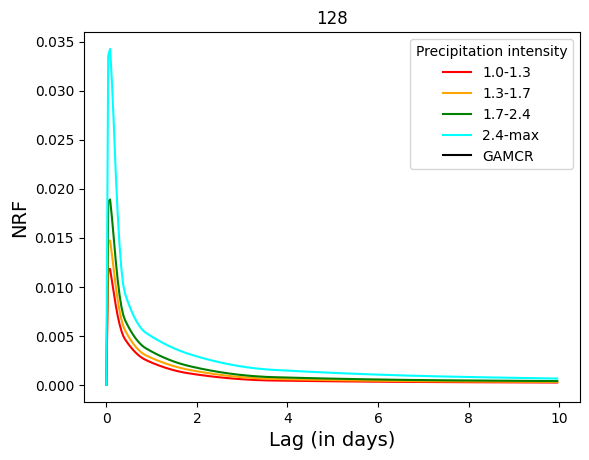

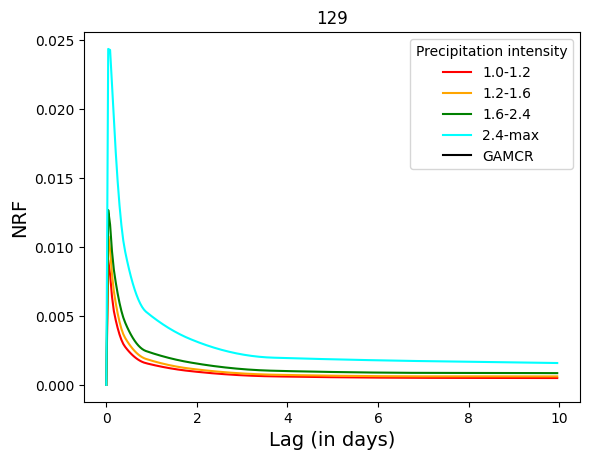

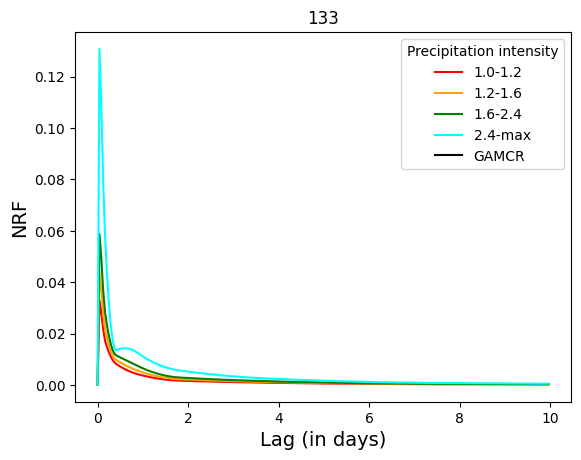

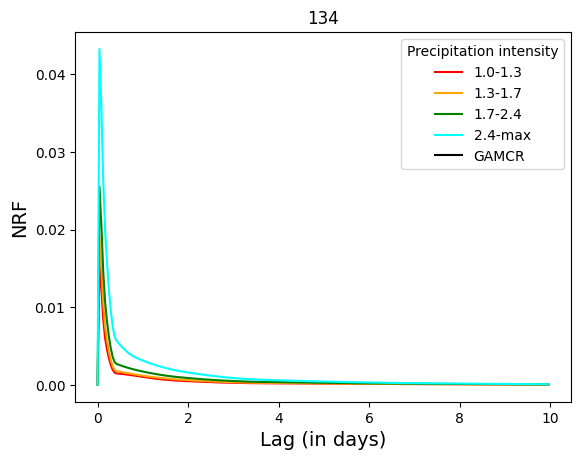

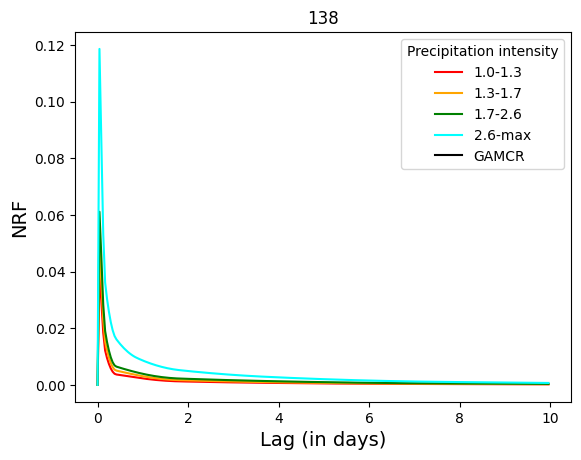

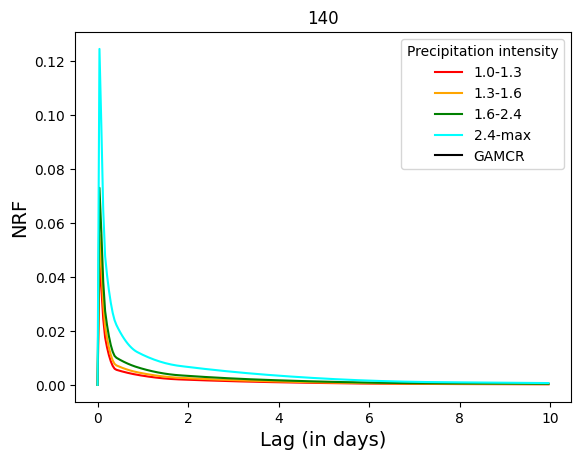

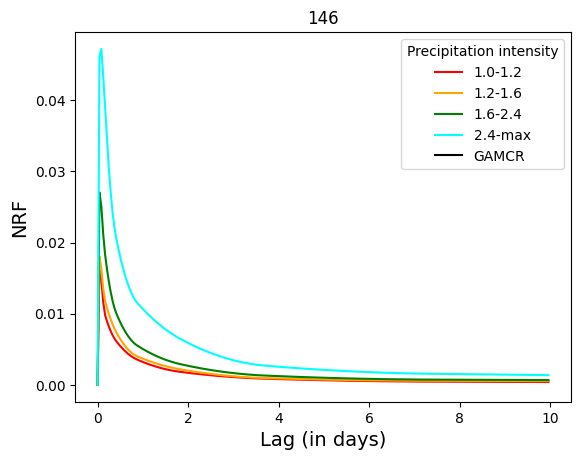

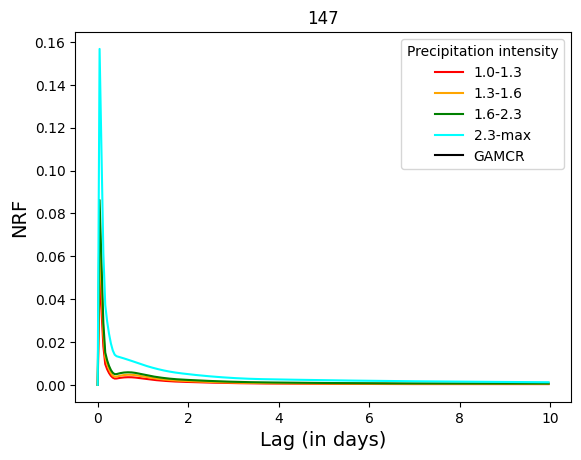

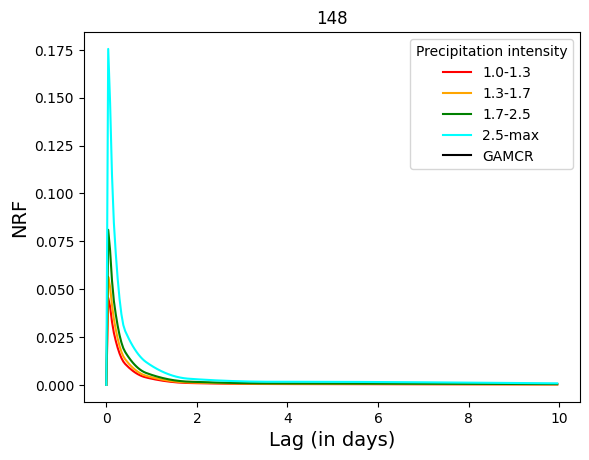

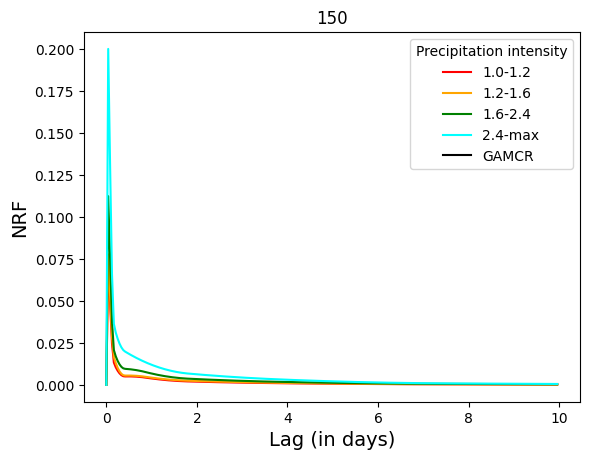

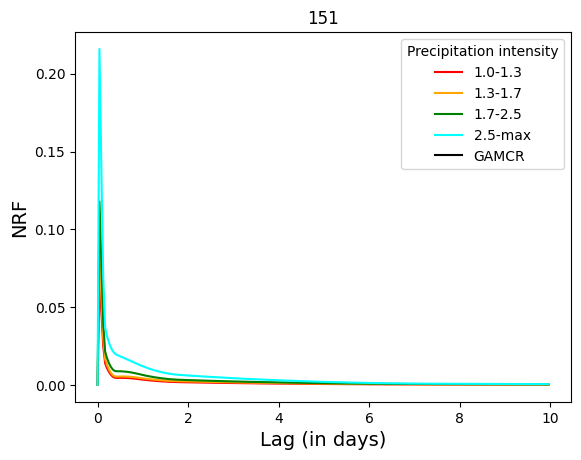

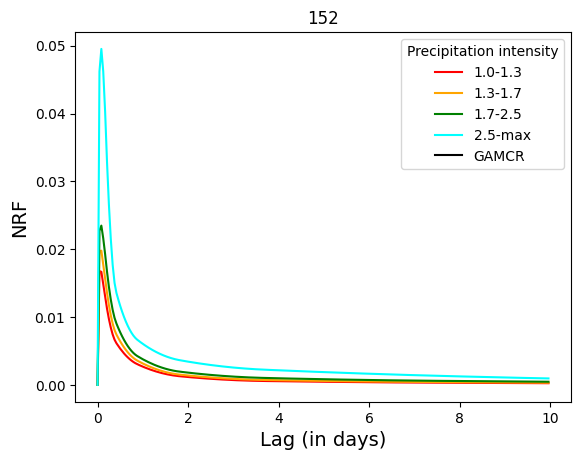

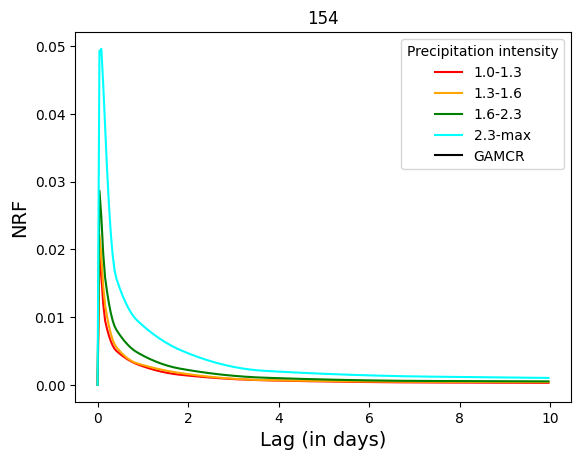

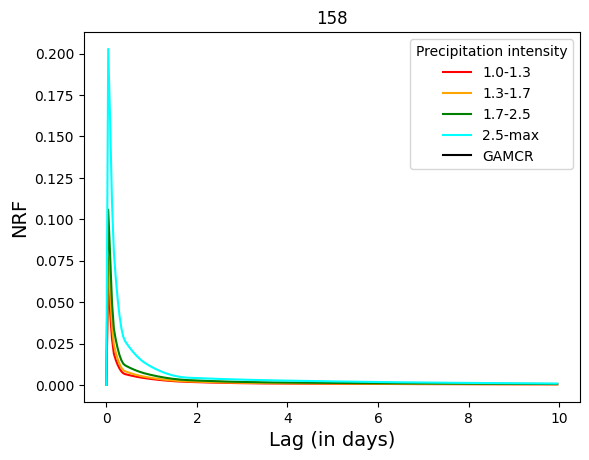

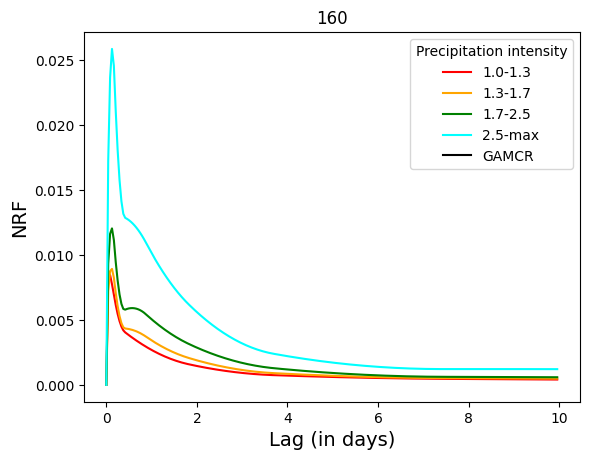

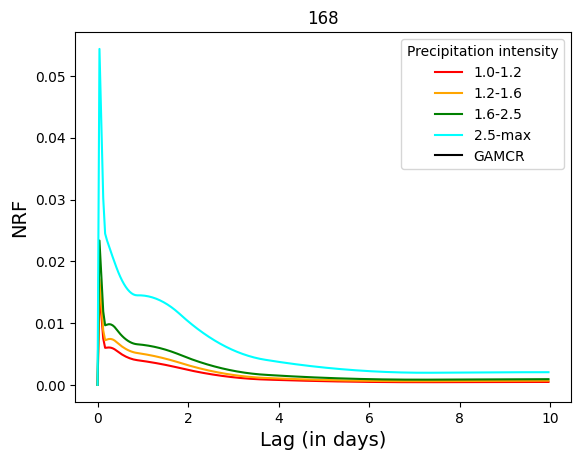

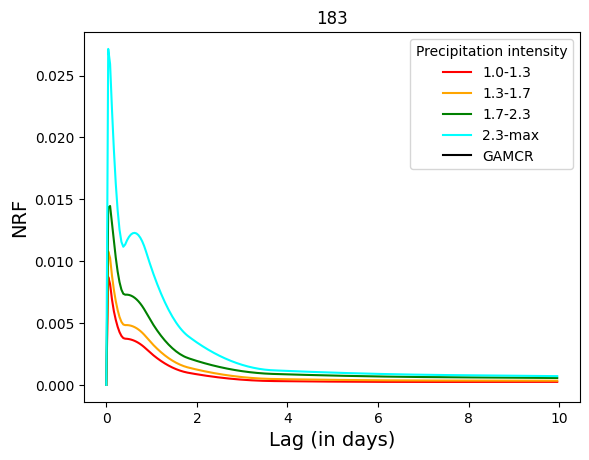

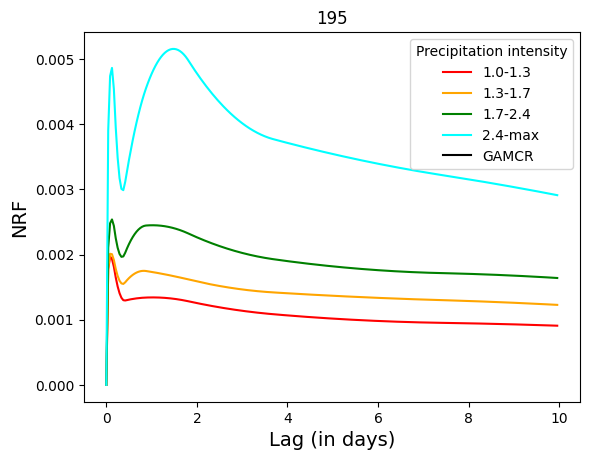

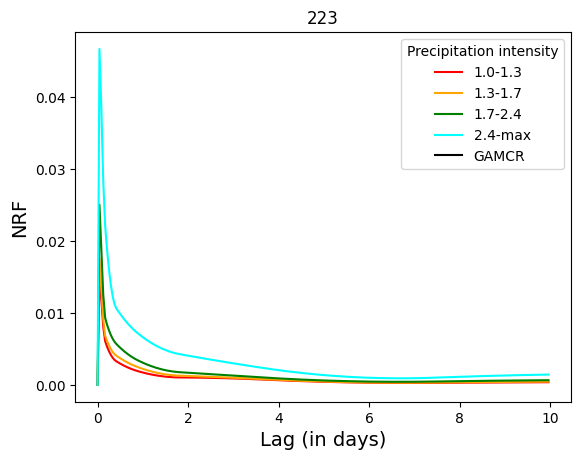

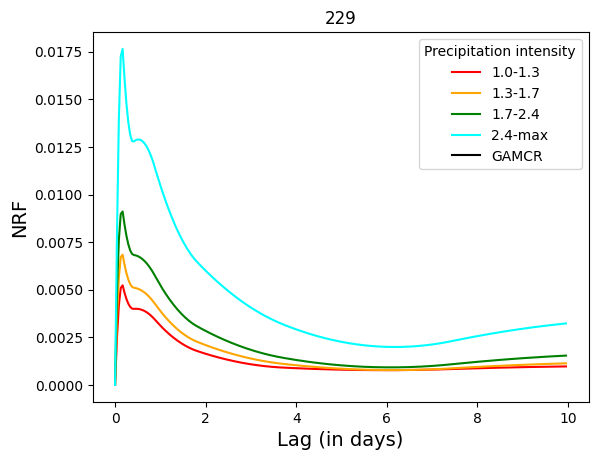

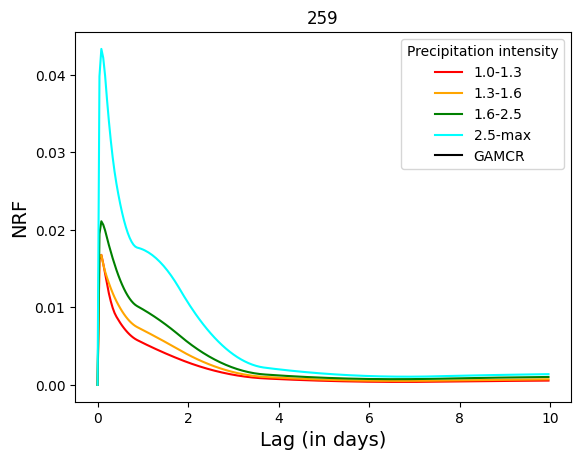

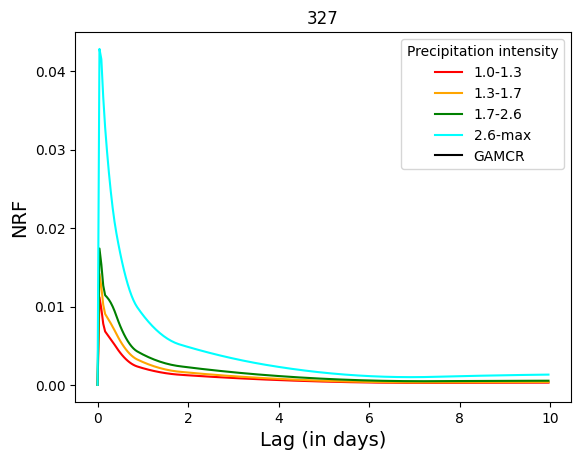

In [5]:
for site in all_sites:
    site_folder = '/mydata/watres/quentin/code/FLOW/hourly_analysis/RES_GAMCR/real_data/{0}/'.format(site)
    GAMCR.resultsanalysis.show_tf_p_or_q(site_folder, site, stratif_wetness=False, maxT=24*10, weighted=True)#, figname='NRF_quantiles_{0}'.format(site))

# Global response

In [40]:
len(all_sites)

71

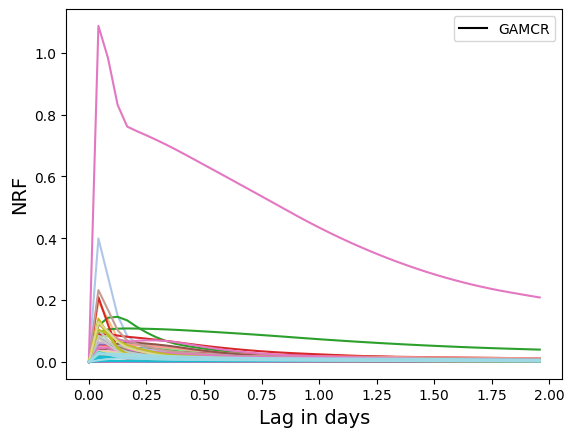

In [37]:
global_path = '/mydata/watres/quentin/code/FLOW/hourly_analysis/RES_GAMCR/real_data/'
GAMCR.resultsanalysis.show_tf_global(global_path, all_sites, log_abs=False, log_ordo=False, weighted=True, alpha=0.025, maxT=2*24, show_sites_labels=False, figsave=True)

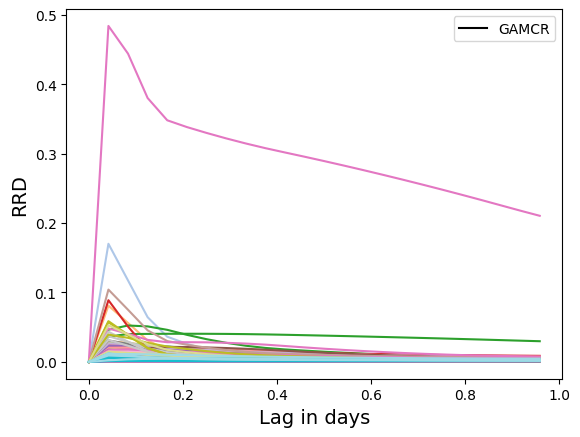

In [8]:
GAMCR.resultsanalysis.show_tf_global(global_path, all_sites, log_abs=False, log_ordo=False, weighted=False,show_sites_labels=False, alpha=0.025, maxT=24)

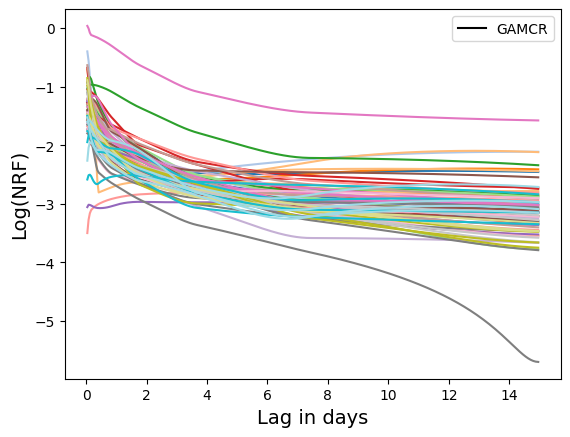

In [38]:
GAMCR.resultsanalysis.show_tf_global(global_path, all_sites, log_abs=False, log_ordo=True, weighted=True, alpha=0.025, maxT=15*24, show_sites_labels=False, figsave=True)

/mydata/watres/quentin/code/FLOW/hourly_analysis/GAMCR/resultsanalysis/visualization_tools.py:410: RuntimeWarning: invalid value encountered in divide
  H_weighted_avg[idx,:] /= norm[idx]
/mydata/watres/quentin/code/FLOW/hourly_analysis/GAMCR/resultsanalysis/visualization_tools.py:411: RuntimeWarning: invalid value encountered in scalar divide
  quantiles_precip[idx] /= norm[idx]


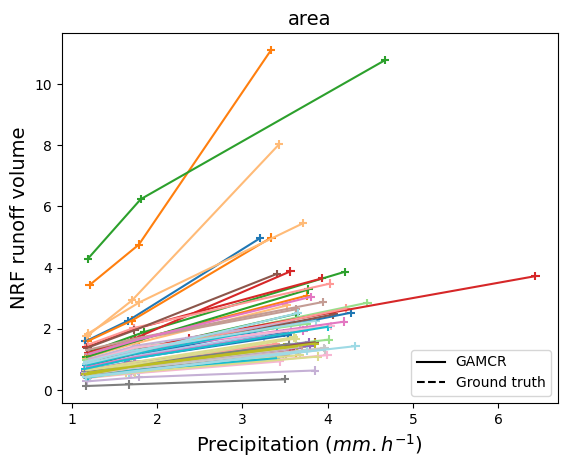

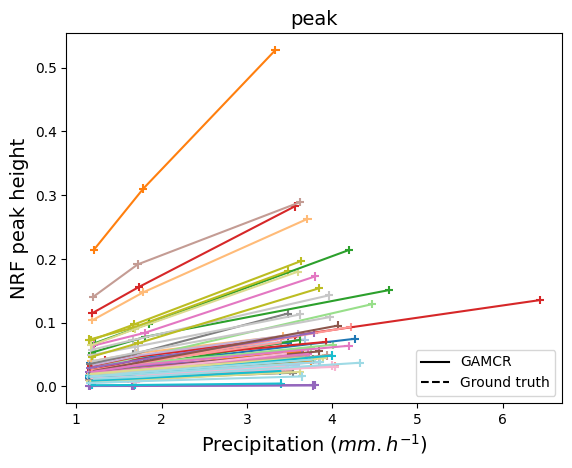

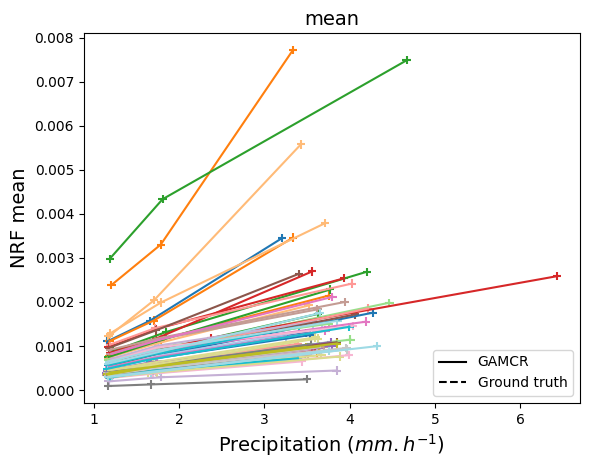

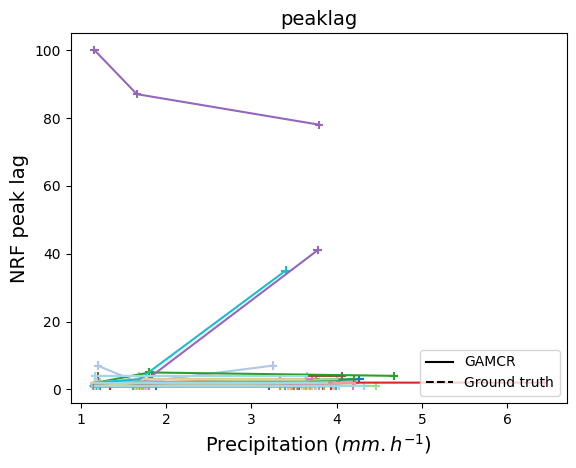

In [10]:
GAMCR.resultsanalysis.show_vs_precip_intensity(global_path, [site for site in all_sites if site !='102'], weighted=True, log_ordo=False, show_sites_labels=False)

In [41]:
def study_site(site_folder, site, stratif_wetness=False, weighted=True, alpha=0.1, maxT=None, figname=None):
    
    feat_space, all_GISID, dffeat = GAMCR.dataset.get_feat_space(all_GISID=[site], get_df=True, normalize=False)
    coef = 3600 * 1000 / (dffeat.loc[site, 'EZG '] * 1000000) 
    df = pd.read_csv(os.path.join(site_folder, f'data_{site}.txt'))
    df = df.fillna(0)
    y = df['q'].to_numpy()
    y = y * coef
    folder = os.path.join(site_folder, "results")
    timeyear = np.load(os.path.join(folder, 'timeyear.npy'))
    yhat = np.load(os.path.join(folder, 'predicted_streamflow.npy'))
    timeyeardf = df['timeyear'].to_numpy()
    idx = np.where(timeyeardf>=timeyear[0])[0][0]
    y = y[idx:]
    y = y[:len(yhat)]

    
    H_weighted_avg = np.load(os.path.join(folder, 'H_weighted_avg.npy'))
    H_avg = np.load(os.path.join(folder, 'H_avg.npy'))
    m = H_avg.shape[1]
    
    with open(os.path.join(folder, 'groups_precip.pkl'), 'rb') as handle:
        groups_precip = pickle.load(handle)
        nJ = len(groups_precip)
    with open(os.path.join(folder, 'groups_wetness.pkl'), 'rb') as handle:
        groups_wetness = pickle.load(handle)
        nQ = len(groups_wetness)
        
    with open(os.path.join(folder, 'group2p_range.pkl'), 'rb') as handle:
        group2p_range = pickle.load(handle)
    with open(os.path.join(folder, 'group2q_range.pkl'), 'rb') as handle:
        group2q_range = pickle.load(handle)
    with open(os.path.join(folder, 'group2nbpoints.pkl'), 'rb') as handle:
        group2nbpoints = pickle.load(handle)

    if stratif_wetness:
        K = nQ
    else:
        K = nJ

    if maxT is None:
        maxT = m

    x = np.arange(0,maxT,1)/24
    colors = ['red', 'orange', 'green', 'cyan', 'blue']
    tf = np.zeros((K,m))
    norm = np.zeros(K)
    idx2legends = ['' for k in range(K)]

    for j in range(nJ):
        for k in range(nQ):
            if stratif_wetness:
                idx = k
                low,up = np.round(group2q_range[nQ*j+k], 3)
                upleg = up if idx!=(nQ-1) else 'max'
                idx2legends[idx] = '{0}-{1}'.format(low,upleg)
                tit_legend = 'Antecedent wetness'
            else:
                idx = j
                low,up = np.round(group2p_range[nJ*j+k], 1)
                upleg = up if idx!=(nJ-1) else 'max'
                idx2legends[idx] = '{0}-{1}'.format(low,upleg)
                tit_legend = 'Precipitation intensity'


            if group2nbpoints[nQ*j+k]>1:
                norm[idx] += group2nbpoints[nQ*j+k]
                tf[idx,:] += H_weighted_avg[nQ*j+k,:] * group2nbpoints[nQ*j+k]

    
    for idx in range(K):
        tf[idx,:] /= norm[idx]


    ntrain = int(len(timeyear)*3/4)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))

    ax1.plot(timeyear[:ntrain], yhat[:ntrain], label='Estimation')
    ax1.plot(timeyear[:ntrain], y[:ntrain], linestyle='--', label='Ground truth')
    ax1.scatter([],[], c='white', label='NSE: {0}'.format(GAMCR.nse( y[:ntrain], yhat[:ntrain] )))
    ax1.set_ylabel('Site GISID {0} \n \n  Streamflow (mm/h)'.format(site), fontsize=13)
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_title('Training data')
    ax1.legend()
    ax2.set_title('Test data')
    ax2.plot(timeyear[ntrain:], yhat[ntrain:], label='Estimation')
    ax2.plot(timeyear[ntrain:], y[ntrain:], linestyle='--', label='Ground truth')
    ax2.scatter([],[], c='white', label='NSE: {0}'.format(GAMCR.nse( y[ntrain:], yhat[ntrain:] )))
    ax2.legend()
    ax2.tick_params(axis='x', labelrotation=90)
    ax2.ticklabel_format(useOffset=False, style='plain')
    for idx in range(K):
        ax3.plot(x[:maxT],tf[idx,:maxT], color=colors[idx])
        ax3.plot([],[], color=colors[idx], label=str(idx2legends[idx]))
    ax3.set_xlabel('Lag (in days)', fontsize=13)

    ax3.legend(title='Precipitation intensity')
    if weighted:
        ax3.set_title('NRF')
    else:
        ax3.set_title('RRD')
    if not(figname is None):
        plt.savefig(f'/mydata/watres/quentin/code/FLOW/hourly_analysis/RES_GAMCR/real_data/study_site_{site}.png',  dpi=250, bbox_inches='tight')
    plt.show()


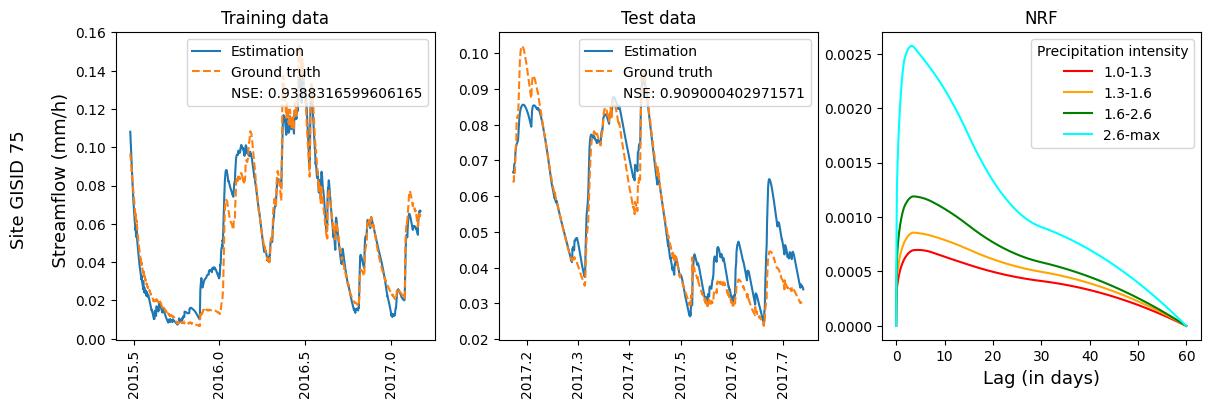

In [49]:
for site in ['75']:
    site_folder = '/mydata/watres/quentin/code/FLOW/hourly_analysis/RES_GAMCR/real_data/{0}/'.format(site)
    study_site(site_folder, site, figname=True, maxT=24*60)